# Matching Phase Igual do Artigo do Hugo com Simulador

Casamento de fase da biblioteca diretamente com os mapas de fase, porém utilizando o simulador para gerar a biblioteca.

## Bibliotecas

In [ ]:
!pip install torch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import time
from tqdm import tqdm

from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image

## Arquitetura Para Usar o Simulador e Criar um Dataframe com ele:

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

# --- 1. Definições de Constantes (do seu código de treino) ---
IMG_SIZE = 64       # 64x64 pixels
MAX_DIM_NM = 520    # O tamanho físico total da célula unitária
N_OUTPUTS = 4       # Saídas do simulador
SIMULATOR_PATH = "/content/simulator_teste_2,.pth" # O modelo que você já treinou

# --- 2. Definição da Função de Desenho (do seu código de treino) ---
def draw_meta_atom_ellipse(L_x_nm, L_y_nm):
    """
    Desenha um meta-átomo de ELIPSE como um array numpy binário.
    """
    scale_factor = IMG_SIZE / MAX_DIM_NM

    # Metade dos eixos em pixels
    # (Seu código usava L_x_nm direto, vou manter, mas
    #  geralmente a_px seria (L_x_nm / 2) * scale_factor.
    #  Vou usar como no seu código para consistência.)
    a_px = (L_x_nm / 2) * scale_factor # CORREÇÃO: Usando /2, pois é o raio
    b_px = (L_y_nm / 2) * scale_factor # CORREÇÃO: Usando /2, pois é o raio

    if a_px <= 0 or b_px <= 0:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    x = np.arange(0, IMG_SIZE)
    y = np.arange(0, IMG_SIZE)
    xx, yy = np.meshgrid(x, y)

    center = (IMG_SIZE - 1) / 2.0

    # Equação da elipse
    term_x = ((xx - center) / a_px) ** 2
    term_y = ((yy - center) / b_px) ** 2

    mask = (term_x + term_y) <= 1

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    img[mask] = 1.0 # Define 1.0 (metal) em todos os pixels dentro da elipse

    return img

# --- 3. Definições das Classes do Modelo (do seu código de treino) ---
class ResBlock(nn.Module):
    """
    Define um bloco ResNet básico
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut_path = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out) # <--- Importar torch.nn.functional as F
        return out

class ResNetSimulator(nn.Module):
    """
    Implementação do Simulator baseado em ResNet.
    """
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = ResBlock(64, 64, stride=1)
        self.layer2 = ResBlock(64, 128, stride=2)
        self.layer3 = ResBlock(128, 256, stride=2)
        self.layer4 = ResBlock(256, 256, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

# --- 4. Carregar o Modelo Treinado ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = None
df_simulado = None

if not os.path.exists(SIMULATOR_PATH):
    print(f"ERRO: Modelo '{SIMULATOR_PATH}' não encontrado.")
    print("Por favor, verifique o nome e o caminho do arquivo .pth")
else:
    try:
        model = ResNetSimulator(in_channels=1, n_outputs=N_OUTPUTS).to(device)
        model.load_state_dict(torch.load(SIMULATOR_PATH, map_location=device))
        model.eval() # <--- MUITO IMPORTANTE: Colocar em modo de avaliação
        print(f"Modelo '{SIMULATOR_PATH}' carregado com sucesso em {device}.")
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        model = None

# --- 5. Gerar 2000 Amostras Simuladas ---
if model is not None:
    N_SAMPLES = 2000
    simulated_data = []

    print(f"Iniciando simulação de {N_SAMPLES} pontos...")

    # --- CORREÇÃO ESTÁ AQUI ---

    # 1. Gerar parâmetros de entrada aleatórios (FORA DO LOOP)
    #    (Seu comentário dizia "aleatórios", então usei np.random.uniform
    #     em vez de linspace, que é o mais correto para amostrar o espaço)
    all_l_x = np.random.uniform(70, 200, N_SAMPLES)
    all_l_y = np.random.uniform(70, 200, N_SAMPLES)

    # Agora, itere N_SAMPLES vezes, pegando um par de cada vez
    for i in tqdm(range(N_SAMPLES)):

        # 1b. Obter os valores DESTA iteração
        l_x = all_l_x[i]
        l_y = all_l_y[i]

        # --- FIM DA CORREÇÃO ---

        # 2. Gerar a imagem do meta-átomo
        #    Agora l_x e l_y são NÚMEROS ÚNICOS (escalares)
        img_np = draw_meta_atom_ellipse(l_x, l_y) # (64, 64)

        # 3. Preparar a imagem para o modelo (replicando seu Dataset)
        # Adiciona dimensão de canal: (1, 64, 64)
        img_np_ch = np.expand_dims(img_np, axis=0)
        # Converte para tensor
        img_tensor = torch.from_numpy(img_np_ch).float()
        # Adiciona dimensão de batch: (1, 1, 64, 64)
        img_batch = img_tensor.unsqueeze(0).to(device)

        # 4. Fazer a predição
        with torch.no_grad():
            preds_tensor = model(img_batch)

        # 5. Coletar resultados
        preds_np = preds_tensor.cpu().numpy()[0] # (4,)

        # Armazena os dados (L_x, L_y, T_x, T_y, F_x, F_y)
        # (A ordem aqui deve ser a mesma do seu treino)
        simulated_data.append([
            l_x,             # O l_x único desta iteração
            l_y,             # O l_y único desta iteração
            preds_np[0],     # Transmitancia_x
            preds_np[1],     # Transmitancia_y
            preds_np[2],     # Fase_x
            preds_np[3]      # Fase_y
        ])

    # 6. Criar o DataFrame
    # (Os nomes das colunas devem seguir a ordem do passo 5)
    column_names = ['L_x', 'L_y', 'Transmitancia_x', 'Transmitancia_y', 'Fase_x', 'Fase_y']
    df_simulado = pd.DataFrame(simulated_data, columns=column_names)

    print(f"\nDataFrame com {len(df_simulado)} dados simulados foi criado.")
    print(df_simulado.head())

    # Opcional: Salvar o dataframe em um arquivo
    df_simulado.to_csv("dataframe_simulado_2000.csv", index=False)
    print("DataFrame salvo em 'dataframe_simulado_2000.csv'")

else:
    print("Simulação não executada pois o modelo não foi carregado.")

Modelo '/content/simulator_teste_2,.pth' carregado com sucesso em cpu.
Iniciando simulação de 2000 pontos...


100%|██████████| 2000/2000 [01:32<00:00, 21.71it/s]


DataFrame com 2000 dados simulados foi criado.
          L_x         L_y  Transmitancia_x  Transmitancia_y    Fase_x  \
0   94.804732  110.886603         0.994894         1.000966 -1.267301   
1  121.233442  162.522885         0.964180         1.003148 -1.184729   
2  104.232433  175.971732         0.993117         0.974745 -0.835666   
3   70.541558   88.641147         1.010446         0.967384 -1.077417   
4   77.338292  193.076591         0.954325         0.930967  0.638927   

     Fase_y  
0 -1.147010  
1 -1.219437  
2 -1.248593  
3 -1.094250  
4 -0.723760  
DataFrame salvo em 'dataframe_simulado_2000.csv'


# Mapas de Fase

Criação do mapa de fase para a polarização x:

In [6]:
def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e pré-processa a imagem alvo usando PIL
    """
    try:
        image = Image.open(image_path).convert('L')
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        return image_array
    except FileNotFoundError:
        print(f"Atenção: Imagem '{image_path}' não encontrada. Criando imagem de teste...")
        target_image = np.zeros(target_size)
        target_image[150:300, 100:200] = 1.0
        target_image[150:200, 200:350] = 1.0
        target_image[250:300, 200:350] = 1.0
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding à imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numérica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    f_cutoff = NA / wavelength
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando método do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape

    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    root_term[root_term < 0] = 0

    H = np.exp(1j * k * z * np.sqrt(root_term))

    if filter_mask is not None:
        H = H * filter_mask

    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlação de Pearson entre duas imagens (valores reais)
    """
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    if np.isnan(correlation):
        return 0.0

    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai região central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))

    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)

    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)

    # Extrai região central e pega a amplitude (np.abs)
    reconstructed = extract_center(np.abs(reconstructed), original_size)

    return np.real(reconstructed)  # Garante valor real

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    Retornar a imagem original e a reconstruída
    """
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    for i in range(num_iter):
        # 1. Propaga para o plano da imagem
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # 2. Mantém a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Calcula correlação para monitorar convergência
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)

        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # 4. Mantém a fase, atualiza amplitude com incidente (unitária)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram) # Amplitude unitária (holograma de fase)

        if (i + 1) % 10 == 0:
            print(f" 	Iteração GS (X) {i+1}/{num_iter}, Correlação: {corr:.4f}")

    phase_final = extract_center(np.angle(U), original_size)

    reconstructed_image = reconstruct_image(phase_final, wavelength, z, dx, NA)

    return target, reconstructed_image, phase_final, correlations

Carregando e pré-processando imagem...
Executando algoritmo de Gerchberg-Saxton...
 	Iteração GS (X) 10/200, Correlação: 0.9517
 	Iteração GS (X) 20/200, Correlação: 0.9583
 	Iteração GS (X) 30/200, Correlação: 0.9607
 	Iteração GS (X) 40/200, Correlação: 0.9618
 	Iteração GS (X) 50/200, Correlação: 0.9628
 	Iteração GS (X) 60/200, Correlação: 0.9634
 	Iteração GS (X) 70/200, Correlação: 0.9638
 	Iteração GS (X) 80/200, Correlação: 0.9641
 	Iteração GS (X) 90/200, Correlação: 0.9644
 	Iteração GS (X) 100/200, Correlação: 0.9647
 	Iteração GS (X) 110/200, Correlação: 0.9650
 	Iteração GS (X) 120/200, Correlação: 0.9651
 	Iteração GS (X) 130/200, Correlação: 0.9652
 	Iteração GS (X) 140/200, Correlação: 0.9653
 	Iteração GS (X) 150/200, Correlação: 0.9654
 	Iteração GS (X) 160/200, Correlação: 0.9655
 	Iteração GS (X) 170/200, Correlação: 0.9656
 	Iteração GS (X) 180/200, Correlação: 0.9658
 	Iteração GS (X) 190/200, Correlação: 0.9660
 	Iteração GS (X) 200/200, Correlação: 0.9661

Corre

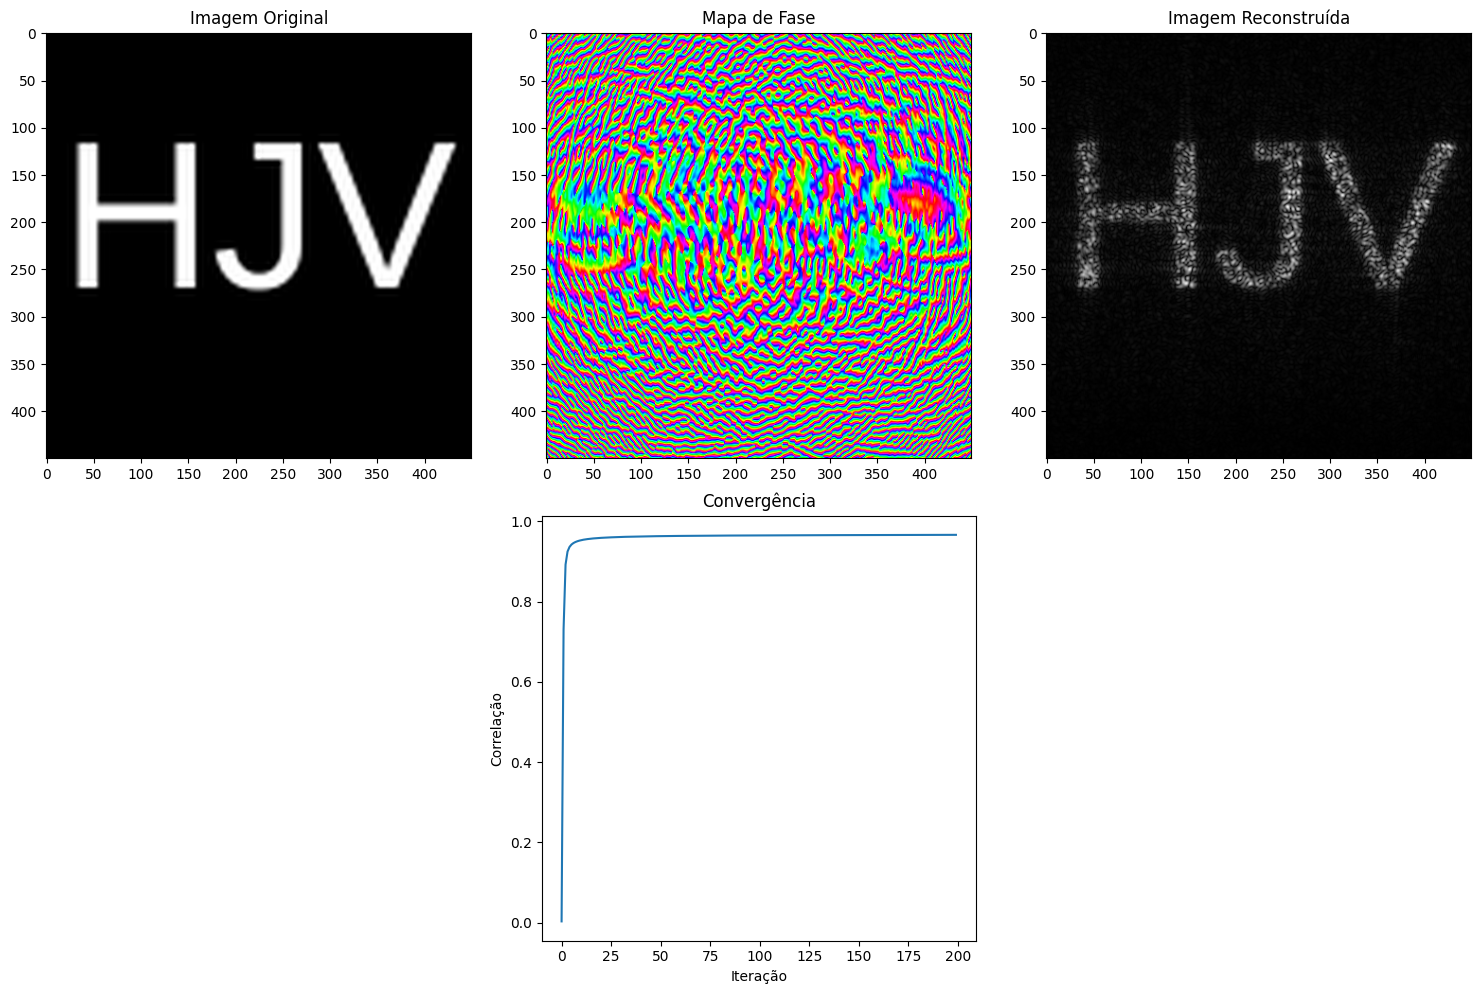

In [7]:
wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 μm
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numérica
num_iter = 200       # número de iterações

print("Carregando e pré-processando imagem...")
target_original = load_and_preprocess_image('/content/HJV.png', target_size=(450, 450))

print("Executando algoritmo de Gerchberg-Saxton...")

img_original, img_reconstruida, mapa_de_fase, correlations = gerchberg_saxton_angular_spectrum(
    target_original,
    wavelength,
    z,
    dx,
    NA,
    num_iter
)
print(f"\nCorrelação final: {correlations[-1]:.4f}")

print(f"Dimensões da Imagem Original: {img_original.shape}")
print(f"Dimensões da Imagem Reconstruída: {img_reconstruida.shape}")
print(f"Dimensões do Mapa de Fase: {mapa_de_fase.shape}")

np.savetxt('phase_map_x_polarization.txt', mapa_de_fase)
np.savetxt('correlations.txt', correlations)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 3, 2)
plt.imshow(mapa_de_fase, cmap='hsv')
plt.title('Mapa de Fase')

plt.subplot(2, 3, 3)
plt.imshow(img_reconstruida, cmap='gray')
plt.title('Imagem Reconstruída')

plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.title('Convergência')
plt.xlabel('Iteração')
plt.ylabel('Correlação')

plt.tight_layout()
plt.show()

## Polarização y:

In [8]:
def generate_dammann_phase_map(
    P: float = 520e-9,
    wavelength: float = 1064e-9,
    supercell_pixels: int = 45,
    n_supercells: int = 10,
    iters_gs: int = 400,
    random_seed: int = 0,
    verbose: bool = True
) -> tuple[np.ndarray, dict, list]:
    """
    Gera o mapa de fase para uma grade de Dammann (spot-cloud) usando o algoritmo GS.
    """
    np.random.seed(random_seed)

    N_super = supercell_pixels
    dx = P
    d = dx * N_super

    # --- Grade k e alvo ---
    # (Esta função usa np.fft, o que não conflita com o Bloco 1)
    kx = np.fft.fftfreq(N_super, d=dx)
    ky = np.fft.fftfreq(N_super, d=dx)
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx_shift, ky_shift)
    K_rad = np.sqrt(KX**2 + KY**2)
    target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
    target_amp = (K_rad <= target_radius).astype(float)

    # --- Algoritmo GS ---
    plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))
    errors = []

    # Loop de iteração para Dammann
    gs_iterator = range(iters_gs)
    if verbose:
        # Cria uma barra de progresso se 'verbose' for True
        gs_iterator = tqdm(range(iters_gs), desc="  Iterações GS (Y)", leave=False)

    for it in gs_iterator:
        far = np.fft.fft2(plane_field)
        far_shift = np.fft.fftshift(far)

        amp_current = np.abs(far_shift)
        err = np.sqrt(np.mean((amp_current / (amp_current.max() + 1e-9) - target_amp)**2))
        errors.append(err)

        far_shift = target_amp * np.exp(1j * np.angle(far_shift))
        far = np.fft.ifftshift(far_shift)

        plane_field = np.fft.ifft2(far)
        plane_field = np.exp(1j * np.angle(plane_field))

    supercell_phase = np.angle(plane_field)

    # --- Construção da Metassuperfície Completa ---
    full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))

    if verbose:
        print(f"  Mapa Dammann (Y) gerado: {full_phase.shape} pixels")

    metrics = {} # Vazio, focado apenas na geração de fase

    return full_phase, metrics, errors


Iniciando Geração de Fase...


  Mapa Dammann (Y) gerado: (450, 450) pixels
Geração de Fase Concluída.
Iniciando análise e plotagem...
Plot 1: Gerando plot_mapa_fase.png...
Plot 2: Gerando plot_erro_gs.png...
Análise: Calculando Far-Field da metassuperfície completa...
Análise: Extraindo ordens de difração...
Análise concluída. Encontradas 1513 ordens propagantes.
Plot 3: Gerando plot_far_field.png...
Plot 4: Gerando plot_ordens_scatter.png...

Todos os plots foram salvos como arquivos .png.

--- Resumo das Ordens ---
    p  q     intensity            k_p            k_q
0 -21 -6  3.025955e+07 -897435.897436 -256410.256410
1 -21 -5  2.756224e+07 -897435.897436 -213675.213675
2 -21 -4  2.966075e+07 -897435.897436 -170940.170940
3 -21 -3  2.624582e+07 -897435.897436 -128205.128205
4 -21 -2  2.435471e+07 -897435.897436  -85470.085470


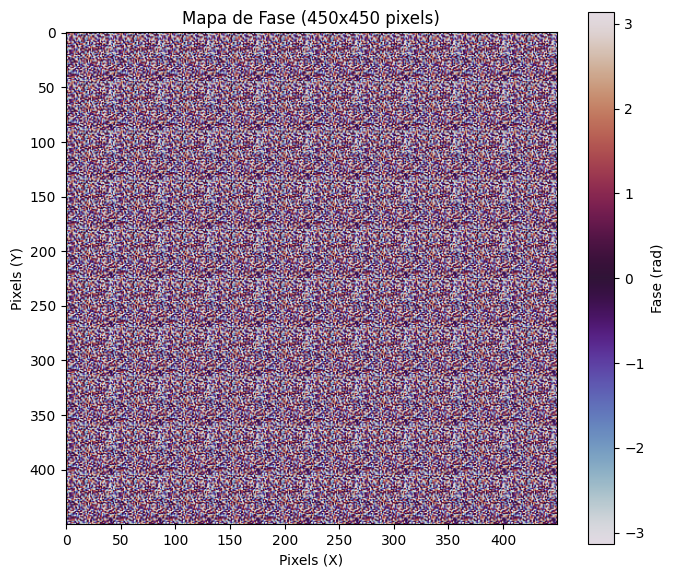

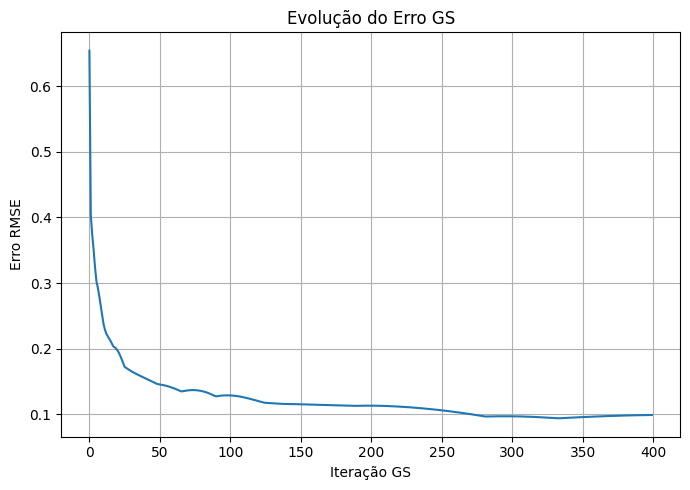

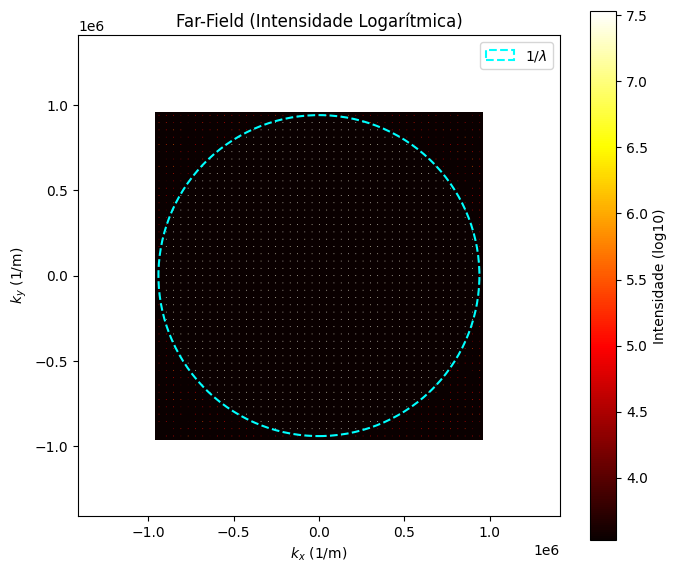

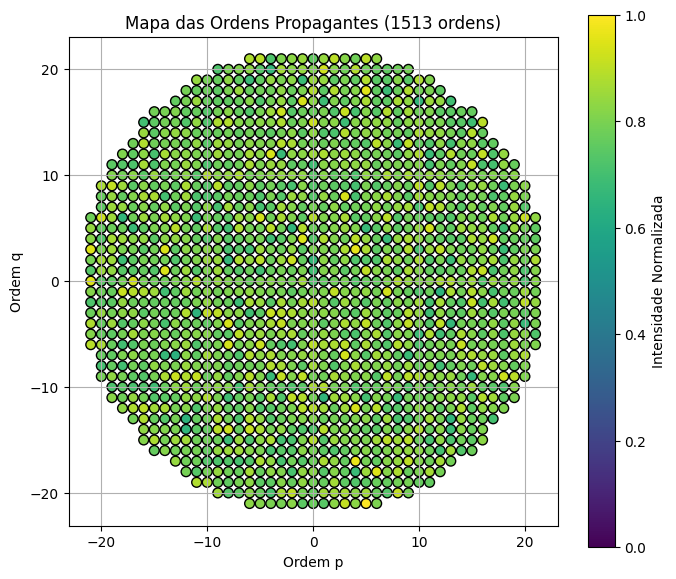

In [11]:
def analyze_and_plot_results(
    full_phase: np.ndarray,
    errors: list,
    P: float,
    wavelength: float,
    supercell_pixels: int
) -> pd.DataFrame:
    """
    Analisa e plota os resultados da metassuperfície.

    Esta função calcula o far-field, analisa as ordens de difração e
    gera os 4 plots principais (Mapa de Fase, Erro GS, Far-Field, Ordens).

    Retorna um DataFrame com os dados das ordens propagantes.
    """

    print("Iniciando análise e plotagem...")

    # --- Plot 1: Mapa de Fase ---
    print("Plot 1: Gerando plot_mapa_fase.png...")
    plt.figure(figsize=(7, 6))
    plt.imshow(full_phase, cmap='twilight', extent=None)
    plt.colorbar(label="Fase (rad)")
    plt.title(f"Mapa de Fase ({full_phase.shape[0]}x{full_phase.shape[1]} pixels)")
    plt.xlabel("Pixels (X)")
    plt.ylabel("Pixels (Y)")
    plt.tight_layout()
    plt.savefig("plot_mapa_fase.png", dpi=150)

    # --- Plot 2: Evolução do Erro ---
    print("Plot 2: Gerando plot_erro_gs.png...")
    plt.figure(figsize=(7, 5))
    plt.plot(errors)
    plt.xlabel("Iteração GS")
    plt.ylabel("Erro RMSE")
    plt.title("Evolução do Erro GS")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plot_erro_gs.png", dpi=150)

    # --- Análise de Far-Field (Células 8 & 9) ---
    print("Análise: Calculando Far-Field da metassuperfície completa...")
    N_full = full_phase.shape[0]
    dx_full = P

    # Criar a grade k
    kx_full = np.fft.fftfreq(N_full, d=dx_full)
    ky_full = np.fft.fftfreq(N_full, d=dx_full)
    kx_full_shift = np.fft.fftshift(kx_full)
    ky_full_shift = np.fft.fftshift(ky_full)

    # Calcular o far-field
    plane_field_full = np.exp(1j * full_phase)
    far_field_full = np.fft.fft2(plane_field_full)
    far_field_full_shift = np.fft.fftshift(far_field_full)
    far_field_intensity = np.abs(far_field_full_shift)**2

    print("Análise: Extraindo ordens de difração...")
    d_supercell = supercell_pixels * P
    max_order = int(np.floor((d_supercell) / wavelength))

    p_range = np.arange(-max_order, max_order + 1)
    q_range = np.arange(-max_order, max_order + 1)
    order_data = []

    for p in p_range:
        for q in q_range:
            k_p = p / d_supercell
            k_q = q / d_supercell

            idx_p = np.argmin(np.abs(kx_full_shift - k_p))
            idx_q = np.argmin(np.abs(ky_full_shift - k_q))

            k_rad_order = np.sqrt(k_p**2 + k_q**2)
            if k_rad_order <= (1.0 / wavelength):
                intensity = far_field_intensity[idx_q, idx_p]
                order_data.append({'p': p, 'q': q, 'intensity': intensity, 'k_p': k_p, 'k_q': k_q})

    df_orders = pd.DataFrame(order_data)
    print(f"Análise concluída. Encontradas {len(df_orders)} ordens propagantes.")

    print("Plot 3: Gerando plot_far_field.png...")
    log_intensity = np.log10(far_field_intensity + 1e-9)
    vmax_val = log_intensity.max()
    vmin_val = vmax_val - 4

    plt.figure(figsize=(7, 6))
    plt.imshow(
        log_intensity,
        cmap='hot',
        extent=[kx_full_shift.min(), kx_full_shift.max(), ky_full_shift.min(), ky_full_shift.max()],
        vmin=vmin_val,
        vmax=vmax_val,
        origin='lower'
    )

    k_max_plot = 1.0 / wavelength
    circle = plt.Circle((0, 0), k_max_plot, color='cyan', fill=False, linestyle='--', linewidth=1.5, label=r'$1/\lambda$')
    plt.gca().add_artist(circle)
    plt.legend(handles=[circle])

    plt.xlim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.ylim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.colorbar(label="Intensidade (log10)")
    plt.title("Far-Field (Intensidade Logarítmica)")
    plt.xlabel(r"$k_x$ (1/m)")
    plt.ylabel(r"$k_y$ (1/m)")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig("plot_far_field.png", dpi=150)

    print("Plot 4: Gerando plot_ordens_scatter.png...")
    if not df_orders.empty:
        plt.figure(figsize=(7, 6))
        norm_intensity = df_orders['intensity'] / (df_orders['intensity'].max() + 1e-9)

        sc = plt.scatter(df_orders['p'], df_orders['q'], c=norm_intensity, cmap='viridis', s=50, edgecolor="k", vmin=0)
        plt.colorbar(sc, label="Intensidade Normalizada")
        plt.xlabel("Ordem p")
        plt.ylabel("Ordem q")
        plt.title(f"Mapa das Ordens Propagantes ({len(df_orders)} ordens)")
        plt.grid(True)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.savefig("plot_ordens_scatter.png", dpi=150)
    else:
        print("Plot 4: DataFrame de ordens vazio, pulando o scatter plot.")

    print("\nTodos os plots foram salvos como arquivos .png.")

    return df_orders

P = 520e-9
wavelength = 1064e-9
supercell_pixels = 45
n_supercells = 10
iters_gs = 400
random_seed = 0

print("Iniciando Geração de Fase...")
full_phase, _, errors = generate_dammann_phase_map(
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels,
    n_supercells=n_supercells,
    iters_gs=iters_gs,
    random_seed=random_seed,
    verbose=True
)
print("Geração de Fase Concluída.")

df_ordens_propagantes = analyze_and_plot_results(
    full_phase=full_phase,
    errors=errors,
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels
)

print("\n--- Resumo das Ordens ---")
print(df_ordens_propagantes.head())

# Matching Phase

Aplicar a mesma lógica do artigo do Hugo.

$min[ (E_{xx} - e^{i*\phi_{xx}}) + (E_{yy} - e^{i*\phi_{yy}}) ]$

In [14]:
# --- 1. PRÉ-CÁLCULO (Amplitude Complexa da Biblioteca) ---
# (Assumindo que 'df_simulado' é o DataFrame da célula anterior)

print("Pré-calculando os campos complexos (Amplitude e Fase) da biblioteca...")

# S_x = Transmitancia_x * exp(j * Fase_x)
df_simulado['E_complex_x'] = df_simulado['Transmitancia_x'] * np.exp(1j * df_simulado['Fase_x'])

# S_y = Transmitancia_y * exp(j * Fase_y)
df_simulado['E_complex_y'] = df_simulado['Transmitancia_y'] * np.exp(1j * df_simulado['Fase_y'])

print("Colunas 'E_complex_x' e 'E_complex_y' adicionadas.")
print("-" * 30)


# --- 2. LOOP DE CASAMENTO DE FASE (MÉTODO DO ARTIGO) ---

print(f"Iniciando casamento de fase para mapas {mapa_de_fase.shape}...")

N_rows, N_cols = mapa_de_fase.shape

# --- Inicialize TODOS os mapas que queremos salvar ---
mapa_Lx_final = np.zeros((N_rows, N_cols))
mapa_Ly_final = np.zeros((N_rows, N_cols))
mapa_fase_x_final = np.zeros((N_rows, N_cols))
mapa_fase_y_final = np.zeros((N_rows, N_cols))
mapa_amp_x_final = np.zeros((N_rows, N_cols)) # <--- NOVO
mapa_amp_y_final = np.zeros((N_rows, N_cols)) # <--- NOVO
mapa_erro_x_final = np.zeros((N_rows, N_cols))
mapa_erro_y_final = np.zeros((N_rows, N_cols))

# --- ALGORITMO DE CASAMENTO DE FASE (PHASE MATCHING) ---
for i in range(N_rows):
    if i % 50 == 0:
        print(f"Processando linha {i} de {N_rows}...")

    for j in range(N_cols):
        # 1. Obter fases e alvos complexos
        # (O alvo ideal tem amplitude 1)
        phi_x = mapa_de_fase[i, j]
        phi_y = full_phase[i, j]
        target_Ex = np.exp(1j * phi_x) # Alvo complexo (Amp=1, Fase=phi_x)
        target_Ey = np.exp(1j * phi_y) # Alvo complexo (Amp=1, Fase=phi_y)

        # 2. Calcular o erro (MÉTODO DO ARTIGO)
        #    Erro = |E_biblioteca - E_alvo_ideal|^2
        erro_x = np.abs(df_simulado['E_complex_x'] - target_Ex)**2
        erro_y = np.abs(df_simulado['E_complex_y'] - target_Ey)**2

        # O erro total considera ambas as polarizações
        erro_total = erro_x + erro_y

        # 3. Encontrar o melhor átomo (o que minimiza o erro complexo)
        idx_melhor_atomo = erro_total.idxmin()
        melhor_atomo = df_simulado.loc[idx_melhor_atomo]

        # 4. Salvar os dados físicos (L_x, L_y)
        mapa_Lx_final[i, j] = melhor_atomo['L_x']
        mapa_Ly_final[i, j] = melhor_atomo['L_y']

        # 5. Salvar os dados de FASE resultantes (do átomo escolhido)
        mapa_fase_x_final[i, j] = melhor_atomo['Fase_x']
        mapa_fase_y_final[i, j] = melhor_atomo['Fase_y']

        # 6. Salvar os dados de AMPLITUDE resultantes (do átomo escolhido)
        mapa_amp_x_final[i, j] = melhor_atomo['Transmitancia_x']
        mapa_amp_y_final[i, j] = melhor_atomo['Transmitancia_y']

        # 7. Salvar os valores de erro final para o átomo escolhido
        mapa_erro_x_final[i, j] = erro_x[idx_melhor_atomo]
        mapa_erro_y_final[i, j] = erro_y[idx_melhor_atomo]

print("Casamento de fase concluído!")
print("Todos os 8 mapas de resultado (baseados em amplitude complexa) foram criados.")

print("Gerando e salvando gráficos de resultados...")

# --- Figura 1: Design Físico e Amplitude Resultante ---
fig1 = plt.figure(figsize=(12, 10))
plt.suptitle("Figura 1: Design Físico e Amplitude da Metassuperfície", fontsize=16, y=1.02)

# Painel 1: L_x
plt.subplot(2, 2, 1)
plt.imshow(mapa_Lx_final, cmap='viridis')
plt.title("Design Final: L_x (nm)")
plt.colorbar(label="Comprimento (nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 2: L_y
plt.subplot(2, 2, 2)
plt.imshow(mapa_Ly_final, cmap='viridis')
plt.title("Design Final: L_y (nm)")
plt.colorbar(label="Comprimento (nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 3: Amplitude X
plt.subplot(2, 2, 3)
plt.imshow(mapa_amp_x_final, cmap='magma', vmin=0, vmax=1)
plt.title("Amplitude Resultante: Pol-X")
plt.colorbar(label="Transmitância (Amplitude)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 4: Amplitude Y
plt.subplot(2, 2, 4)
plt.imshow(mapa_amp_y_final, cmap='magma', vmin=0, vmax=1)
plt.title("Amplitude Resultante: Pol-Y")
plt.colorbar(label="Transmitância (Amplitude)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
# Salva a figura 1
plt.savefig("design_fisico_e_amplitude.png", dpi=300, bbox_inches='tight')
plt.show()
print("Gráfico 'design_fisico_e_amplitude.png' salvo.")


# --- Figura 2: Comparação dos Mapas de Fase ---
fig2 = plt.figure(figsize=(12, 10))
plt.suptitle("Figura 2: Comparação dos Mapas de Fase (Alvo vs. Metassuperfície)", fontsize=16, y=1.02)

# Painel 1: Fase Alvo X
plt.subplot(2, 2, 1)
plt.imshow(mapa_de_fase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Alvo: Pol-X (Holograma)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 2: Fase Alvo Y
plt.subplot(2, 2, 2)
plt.imshow(full_phase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Alvo: Pol-Y (Dammann)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 3: Fase Meta X
plt.subplot(2, 2, 3)
plt.imshow(mapa_fase_x_final, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Metassuperfície: Pol-X (Resultado)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 4: Fase Meta Y
plt.subplot(2, 2, 4)
plt.imshow(mapa_fase_y_final, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Metassuperfície: Pol-Y (Resultado)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
# Salva a figura 2
plt.savefig("comparacao_fase_alvo_vs_meta.png", dpi=300, bbox_inches='tight')
plt.show()
print("Gráfico 'comparacao_fase_alvo_vs_meta.png' salvo.")

Output hidden; open in https://colab.research.google.com to view.

Calculando métricas finais (RMSE de Fase e Transmissão Média)...

--- RMSE de Fase (Alvo vs. Resultado) ---
  Pol-X (Holograma): 0.8293 rad (ou 47.52 graus)
  Pol-Y (Dammann):   1.0793 rad (ou 61.84 graus)

--- Transmissão Média (Proxy de Eficiência) ---
  Amplitude Média Pol-X: 0.9752 (Intensidade Média: 0.9530)
  Amplitude Média Pol-Y: 0.9395 (Intensidade Média: 0.8847)

Gerando histogramas de erro de fase...


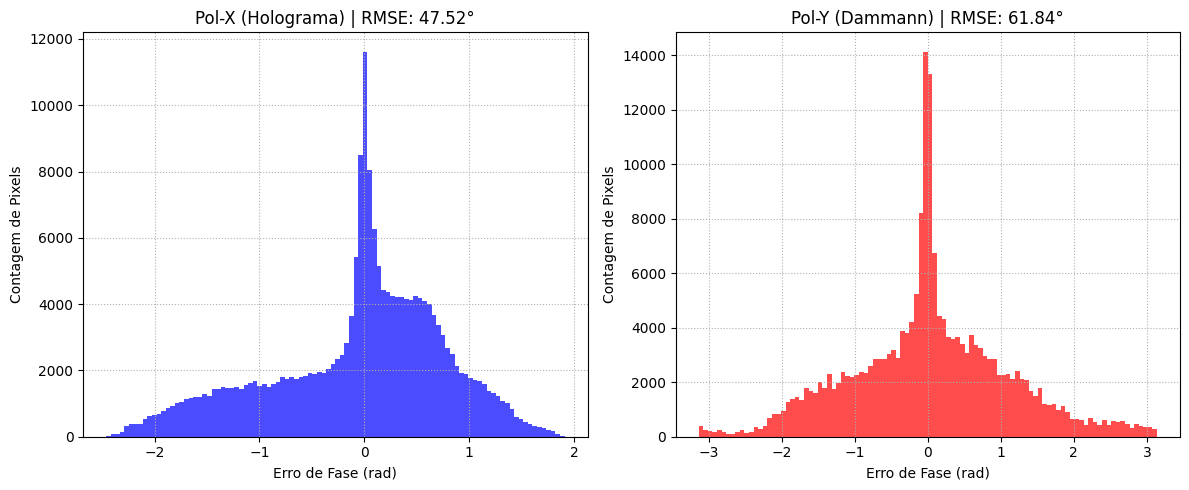

In [15]:
print("Calculando métricas finais (RMSE de Fase e Transmissão Média)...")

# --- 1. Cálculo do RMSE da Fase (em Radianos e Graus) ---

# É crucial usar np.angle para calcular a diferença de fase "enrolada" (wrapped)
# diff = alvo * conjugado(resultado)
# phase_error = angle(diff)

# Polarização X (Holograma)
diff_x = np.exp(1j * mapa_de_fase) * np.conj(np.exp(1j * mapa_fase_x_final))
phase_error_x_rad = np.angle(diff_x)
rmse_x_rad = np.sqrt(np.mean(phase_error_x_rad**2))
rmse_x_deg = np.rad2deg(rmse_x_rad)

# Polarização Y (Dammann)
diff_y = np.exp(1j * full_phase) * np.conj(np.exp(1j * mapa_fase_y_final))
phase_error_y_rad = np.angle(diff_y)
rmse_y_rad = np.sqrt(np.mean(phase_error_y_rad**2))
rmse_y_deg = np.rad2deg(rmse_y_rad)

print("\n--- RMSE de Fase (Alvo vs. Resultado) ---")
print(f"  Pol-X (Holograma): {rmse_x_rad:.4f} rad (ou {rmse_x_deg:.2f} graus)")
print(f"  Pol-Y (Dammann):   {rmse_y_rad:.4f} rad (ou {rmse_y_deg:.2f} graus)")


# --- 2. Cálculo da Eficiência (Transmissão Média de Amplitude) ---

# Isso serve como um proxy para a eficiência, medindo a amplitude média
# dos meta-átomos escolhidos.
mean_amp_x = np.mean(mapa_amp_x_final)
mean_amp_y = np.mean(mapa_amp_y_final)

# A eficiência de intensidade seria (amplitude^2)
mean_intensity_x = np.mean(mapa_amp_x_final**2)
mean_intensity_y = np.mean(mapa_amp_y_final**2)

print("\n--- Transmissão Média (Proxy de Eficiência) ---")
print(f"  Amplitude Média Pol-X: {mean_amp_x:.4f} (Intensidade Média: {mean_intensity_x:.4f})")
print(f"  Amplitude Média Pol-Y: {mean_amp_y:.4f} (Intensidade Média: {mean_intensity_y:.4f})")

# --- 3. Plotar Histogramas de Erro ---
print("\nGerando histogramas de erro de fase...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma Erro de Fase X
ax1.hist(phase_error_x_rad.flatten(), bins=100, color='blue', alpha=0.7)
ax1.set_title(f"Pol-X (Holograma) | RMSE: {rmse_x_deg:.2f}°")
ax1.set_xlabel("Erro de Fase (rad)")
ax1.set_ylabel("Contagem de Pixels")
ax1.grid(True, linestyle=':')

# Histograma Erro de Fase Y
ax2.hist(phase_error_y_rad.flatten(), bins=100, color='red', alpha=0.7)
ax2.set_title(f"Pol-Y (Dammann) | RMSE: {rmse_y_deg:.2f}°")
ax2.set_xlabel("Erro de Fase (rad)")
ax2.set_ylabel("Contagem de Pixels")
ax2.grid(True, linestyle=':')

plt.tight_layout()
plt.savefig("histograma_erro_fase.png", dpi=150)
plt.show()